In [141]:
import wikipedia
wikipedia.set_lang('ja')
p = None
# p = wikipedia.page('朝井リョウと加藤千恵のオールナイトニッポン0(ZERO)')
# p = wikipedia.page('ウレロ☆シリーズ')
p = wikipedia.page('怪奇恋愛作戦')
# p = wikipedia.page('アルコ&ピースのオールナイトニッポンシリーズ')
# p = wikipedia.page(pageid=129204)
# p = wikipedia.page('水曜どうでしょう')
# p = wikipedia.page('おぎやはぎのメガネびいき')
# p = wikipedia.page('リーガルハイ')
# p = wikipedia.page('リバースエッジ大川端探偵社')
# p = wikipedia.page('SPEC〜警視庁公安部公安第五課 未詳事件特別対策係事件簿〜')
# p = wikipedia.page('勝手にふるえてろ')
# p = wikipedia.page('ストロベリーナイト(テレビドラマ)')
# p = wikipedia.page('アイアンマン (映画)')
# print p.html()
# print p

In [142]:
import re
import numpy as np
import wikipedia
import bs4.element as bs4elem
from bs4 import BeautifulSoup

# todo handle English+漢字, '-.,' in the name
EXCEPTION = [u'A・T・C事務所',u'Scope co.,ltd.', u'4-Legs',  u'オア・グローリー神宮前店', u'インダストリアル・ライト&マジック']

# convert unicode to utf-8 if data is unicode
def utf(data):
    if isinstance(data, unicode):
        data = data.encode('utf-8')
    return data

# return true if data include only Katakana and alphabet
def isKatakanaOrEng(data):
    for d in data:
        if not ( '゠' <= utf(d) <= 'ヿ' or re.search('\w', utf(d)) ):
            return False
    
    return True

class WikiScraper(object):
    def __init__(self):
        self._name = ''
        self._page = ''
        self._bsObj = None
        self._headlines = []
        self._headline_tag = 'h3'
        self._last_key = ''
        self._result = dict()

    # return string of 'key : value \n'
    def __str__(self):
        output = self._name + '\n'
        for k, v in self._result.items():
            output +=  k + ' : ' 
            for staff in set(v):
                output += staff + ',       '
            output += u'\n'
        return output.encode('utf-8')
    
    # load html data from wikipedia
    # name: title of wikipage
    # lang: wikipedia language
    # pageid : id of wikipage.
    def load_wiki(self, name, lang='ja', pageid=np.nan):
        self._name = name
        wikipedia.set_lang(lang)
        try:
            if np.isnan(pageid):
                self._page = wikipedia.page(self._name)
            else:
                self._page = wikipedia.page(pageid=pageid)
            self._bsObj = BeautifulSoup(self._page.html(), "html.parser")   
        except:
            print('Can not open wikipage of '+self._name+' with lang '+lang)    
    
    # load html
    # name: title of wikipage
    # html: html string
    def load_html(self, name, html):
        self._bsObj = BeautifulSoup(html, "html.parser")   
        self._name = name
    
    # find headline
    # name name of headline, e.g. スタッフ
    def find_headline(self, name):
        headers = self._bsObj.find_all(class_='mw-headline')
        self._headlines = []
        for h in headers:
                if re.search(name, h.text):
                    self._headline_tag = h.parent.name
                    self._headlines.append(h)

    # cleauup text
    # wrapper function
    # remove brackets, blank, and \n
    def cleanup_text(func):
        def wrapper(self, key, data):
            value = []
            data = data.encode('utf-8')
            data = re.sub('(［|\[).+?(］|\])','', data) #remove brackets
            data = re.sub('(（|\(|\（).+?(）|\）|\))','', data) #remove brackets
            data = data.strip()  #remove \n, and blank from head and tail
            
            #exception
            for e in EXCEPTION:
                if e.encode('utf-8') in data:
                    value.append(e)
                    data = data.replace(e.encode('utf-8'),'')
            
            value = func(key, data, value)
            key = key.strip()
            if key in self._result:
                self._result[key].extend(value)
            else:
                 self._result[key] = value

        return wrapper

    # cleanup value
    # separate line with , / -> and etc. 
    @cleanup_text
    def cleanup_value_list(key, data, value):
        data = re.split('-', data)[0]
        
        data = re.split(u'[,、/／→\n]', data.decode('utf-8')) #separate multiple staffs    
        for d in data:
            d = d.strip()
            if not isKatakanaOrEng(d): #separate with '・' for ウレロシリーズ
                value.extend(re.split(u'[・]', d)) #separate multiple staffs    
#             value.extend(re.split(u'[,、/／→\n]', data.decode('utf-8'))) #separate multiple staffs    
            else:
                value.append(d) # do not separate with '・' for foregin people
#             value.extend(re.split(u'[,、/・／→\n]', data.decode('utf-8'))) #separate multiple staffs    

        for i, v in enumerate(value): #remove ※
            value[i]  = re.split(u'※|●', v)[0].strip()
        
        return value

    # cleanup value
    # separate line with , / -> and etc. 
    @cleanup_text
    def cleanup_value_infobox(key, data, value): 
        data = re.split(u'[※|●]', data)[0]
        data = re.split(u'[,、/→\n]', data.decode('utf-8')) #separate multiple staffs    
        for d in data:
            d = d.strip()
            if not isKatakanaOrEng(d): #separate with '・' for ウレロシリーズ
                value.extend(re.split(u'[・]', d)) #separate multiple staffs    
            else:
                value.append(d) # do not separate with '・' for foregin people

        return value
    
    # get list data
    def find_list(self, elt, parent=''):
        # recursive process if there are dl or ul
        for e in elt.find_all(['dl', 'ul']):
#             print e.parent.text
            if e.parent is not None:
                temp =  e.parent.text.split('\n')[0]
                if temp:
                    # researve text as parents
                    parent += e.parent.text.split('\n')[0] + ' '
                    self._last_key = parent
#             for s in e.parent.strings:
#                 parent += s.strip() + ' '
#                 self._last_key = parent
# #                 print parent
#                 break            
            self.find_list(e, parent)
            parent = ''
            if e.parent is not None:
                e.parent.decompose()
        
        # get data from each dd, li or dt
        for e in elt.find_all(['dd', 'li', 'dt']):
            data = e.text
            
            if e.name == 'dd':
                # add data if there is data already ref:朝井リョウ・加藤千恵のオールナイトニッポン staff
                if self._result.get(self._last_key) is not None:
                    data = self._result[self._last_key][-1]+ data
                key = self._last_key
                self._last_value = ''

            elif e.name == 'dt':
                # researve data as a parent
                parent = data
                self._last_key = parent
                continue
                
            elif not re.search(u'[:：-＝\-\=]',data): 
                # if data do not have :, - and etc, i.e. the separator of role and people, save data as a parent
                if parent == '':
                    parent = self._last_key
                key = parent.strip()
                self._last_value = ''

            else:
                #temp for 水曜どうでしょう　& アルピーANN
                if parent != '':
                    # if parents is not empty, set parent as key
                    key = parent
                    if re.search(u'：',data):
                        #if ':' is in data, split and data[0] is key and others will be data
                        datas = re.split(u'：', data)
                        key += datas[0]
                        
                        # connect data except for data[0] in case data has multiple ':'
                        data_temp = ''
                        for d in datas[1:]:
                            data_temp += d
                        data = data_temp
                    
                    elif re.search(u'-',data):
                        # separate data with '-'  and set first one as data, e.g. アルコ&ピースのANN
                        data = re.split(u'-', data)
                        key = parent
                        data = data[0]
                        
                else:
                    if re.search(u'[:：-＝\-\=]',data): 
                        # if parent is empty, separate data and set [0] as key and others as data
                        datas = re.split(u'[:：-＝\-\=]', data)
                        key = datas[0].strip() 
                        
                        data_temp = ''
                        for d in datas[1:]:
                            data_temp += d
                        data = data_temp

                    else :
                        #if parent is empty and no separator, use last key and
                        key = self._last_key
            
            value = self.cleanup_value_list(key, data)

            self._last_key = key
                
    def get_list_from_headline(self, name):
        self.find_headline(name)
        for headline_start in self._headlines:
            finish = False
            # get html between finded headline and next h[1-6]
            for elt in headline_start.parent.nextSiblingGenerator():
                if elt.name is not None and re.match('h[1-6]', elt.name) and elt.name <= self._headline_tag:
                    break

                if hasattr(elt, 'text'):
                    self.find_list(elt)

    def find_tr(self, table):
        rows = table.findAll('tr')
        for row in rows:
            if len(row.findAll('tr')):
                self.find_tr(row)
            else:
                index = row.find('th')
                if index is not None:
                    key = index.get_text()
                    value = row.find('td')
                    if value is not None:
                        # replace <br> with \n  to get by .text()
                        value_str = re.sub('</*br/*>', '\n', str(value))
                        value = BeautifulSoup(value_str, "html.parser")
        #                    value = value.get_text().split('\n')
                        value = self.cleanup_value_infobox(key, value.get_text())
        #                     self._result[key] = value


    def get_table(self, class_name='infobox'):
        tables = self._bsObj.findAll('table',{'class':class_name})
        for table in tables:
            self.find_tr(table)
                    
wsc = WikiScraper()
#wsc.load_wiki('朝井リョウと加藤千恵のオールナイトニッポン0(ZERO)', 'ja')
wsc.load_html(p.title, p.html())
# wsc.load_wiki(u'攻殻機動隊', lang='ja', pageid=129204)
wsc.get_list_from_headline(u'.*スタッフ')
wsc.get_table('infobox')
# print '-----------------------------'
print wsc

怪奇恋愛作戦
外部リンク : 公式サイト,       
監督 : 白石和彌,       濱谷晃一,       ケラリーノ・サンドロヴィッチ,       
スタントコーディネーター : 高槻祐士,       
放送国 : 日本,       
ジャンル : ラブコメディ,       
特殊メイクデザイン・造型 : 藤原カクセイ,       林屋陽二,       吉田茂正,       
オープニング : 女王蜂「ヴィーナス」,       
オープニングテーマ : 女王蜂「ヴィーナス」,       
エンディングタイトルロゴ&イラスト : ステレオテニス,       
制作局 : テレビ東京,       
ガンエフェクト : 会田文彦,       
プロデューサー : 濱谷晃一,       小松俊喜,       
チーフプロデューサー : 中川順平,       
タイトルバック : 上田大樹,       
放送時間 : 土曜0:12 - 0:52,       
撮影 : 神田創,       
製作著作 : 「怪奇恋愛作戦」製作委員会,       
コンテンツプロデューサー : 五箇公貴,       
放送期間 : 2015年1月10日 - 3月28日,       
エンディングアニメーション : 北村みなみ,       せきやすこ,       
脚本 : ケラリーノ・サンドロヴィッチ,       田中眞一,       小峯裕之,       関谷崇,       
音楽 : 鈴木慶一,       
助監督 : 鬼頭理三,       
製作総指揮 : 中川順平,       
エンディングテーマ : 電気グルーヴ「Fallin' Down」,       
出演者 : 緒川たまき,       麻生久美子,       坂井真紀,       仲村トオル,       
アシスタントプロデューサー : 小松幸敏,       
エンディング : 電気グルーヴ「Fallin' Down」,       
照明 : 丸山和志,       
制作 : 楽映舎,       テレビ東京,       



In [155]:
import pandas as pd
data = pd.read_csv("contents.csv",index_col=0)
wscs = []
for i in data.index.values:
    wsc = WikiScraper()
    wsc.load_wiki(i.decode('utf-8'), pageid=data.at[i, 'id'], lang='ja')
#         wsc.load_wiki(i.decode('utf-8'), 'ja')
# #     wsc.load_html(p.html())
    if wsc._bsObj is not None:
        wsc.get_list_from_headline(u'.*スタッフ')
        wsc.get_table('infobox')
    
    wscs.append(wsc)
    
    print i
    print '-------------------------------------'
    print wsc
    print '+++++++++++++++++++++'

たりないふたり
-------------------------------------
たりないふたり
製作委員会 : 堀越大,       篠田大暢,       友定紘子,       
外部リンク : 公式サイト,       
カメラ : 高橋元弘,       
放送国 : 日本,       
デザイン : 熊崎真知子,       
MIX : 小原正広,       滝口祐造,       
編成企画 : 植野浩之,       
制作協力 : アンメック,       
CAM : 中村哲也,       
ジャンル : バラエティ番組,       
製作著作 : vap,       「もっとたりないふたり」製作委員会,       
チーフプロデューサー : 松崎聡男,       
音効 : 小田切暁,       
デスク : 富重裕子,       
編成 : 脇山浩一,       横田崇,       
美術プロデューサー : 大川明子,       
ロケ技術 : NiTRO,       
構成 : 永井ふわふわ,       谷口マサヒト,       佐藤満春,       林田晋一,       成瀬正人,       飯塚大悟,       
TK : 山際慎子,       長坂真由美,       
制作局 : 日本テレビ,       
ナレーター : 杉上佐智枝,       古市幸子,       山下美穂子,       
TM : 木村博靖,       小椋敏宏,       
プロデューサー : 松崎聡男,       毛利忍,       佐藤俊一,       
演出 : 安島隆,       新井秀和,       
AD : 小野亮太,       小田圭吾,       小松崎由実,       
VE : 塩原和益,       
営業 : 川北愛子,       
放送時間 : 水曜日1:29 - 1:59,       土曜日1:58 - 2:28,       
イベント事業部 : 岩本公平,       
モニター : 小内一豊,       
AP : 平野綾音,       
VAP : 田原英司,       宮崎孝行,       
放送期間 : 2014年4月12日 -

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Threshold:  1.0
 node num before simplify: 321
 node num after simplify: 134


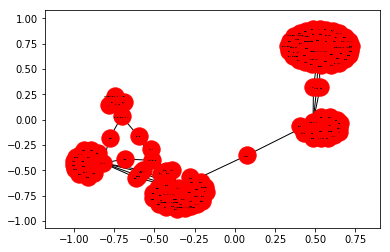

In [156]:
threshold = 1.0
max_number_of_nodes = 200

import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

key_rm = [u'放送期間', u'放送時間', u'公開']
value_rm = [u'', u'日本', u'日本語', u'英語', u'公式サイト', u'ほか', u'ステレオ放送', u'文字多重放送',u'歴代エンディングテーマを参照',u'公式サイト']

for wsc in wscs:
    
    point = float(data.at[wsc._name.encode('utf-8'), 'ポイント'])
    G.add_node(wsc._name, genre='content', point=point)
    
    for k, v in wsc._result.items():
        #add first genre to node attribute
        if k == u'ジャンル':
            if len(v)==0:
                G.node[wsc._name]['genre'] = v
            else:
                G.node[wsc._name]['genre'] = v[0]
        elif k not in key_ex:
            for attr in v:
                if attr not in data.index.values: #do nothing for contents itself
                    if G.node.get(attr) is None: #first time
                        G.add_node(attr, genre='attribute', point=point)
                    else: # from second time
                        G.node[attr]['point'] += point
                    G.add_edge(wsc._name, attr, relation=k) 

# remove nodes for visualization
while len(G.nodes)>max_number_of_nodes:
    print 'Threshold: ', threshold
    print ' node num before simplify:', len(G.nodes)
    # remove.extend([node for node,degree in dict(G.degree()).items() if degree < 3])
    value_rm.extend([node for node in G.nodes if  G.node[node]['point'] < threshold and G.node[node]['genre'] is 'attribute'])
    G.remove_nodes_from(value_rm)
    print ' node num after simplify:', len(G.nodes)
    threshold += 0.5

#mix the closed genres
for v in data.index.values:
    title = v.decode('utf-8')
    if re.search( u'(.*バラエティ.*)|(.*お笑い.*)', G.node[title]['genre']):
        G.node[title]['genre'] = u'バラエティ'
    if re.search( u'.*ドラマ.*', G.node[title]['genre']):
        G.node[title]['genre'] = u'ドラマ'
    if re.search( u'.*SF.*', G.node[title]['genre']):
        G.node[title]['genre'] = u'SF'

nx.draw_networkx(G,font_family='AppleGothic',font_size =0.8)
plt.show()
nx.write_gexf(G, 'result.gexf')